# Sales of Summer Clothes in E-commerce: Factors Affecting Merchant Income

The [Sales of Summer Clothes in E-commerce Dataset](https://www.kaggle.com/jmmvutu/summer-products-and-sales-in-ecommerce-wish) is a dataset consisting of product listings from the [Wish](https://wish.com) platform. The dataset consists of a wide variety of categorical and numerical features related to each product listing, including price, tags set by seller,  and units sold. This project aims to identify from the available features of the dataset the most informative factors affecting the merchant income for a given item, as well as the patterns observed on those products that perform better compared to their competitors. We will identify various metrics that best quantifies the quality of each product. In addition, using the features of this dataset, various models will be used for predictiion of merchant income for each product.

The following is the list of topics covered in this project:

   - #### Initial Data Cleaning
       - Removal of uninformative features
       - Dealing with null values
       - Examination of remaining features
       - Cleaning up relevant features
   - #### Exploratory Data Analysis (EDA)
       - Observing the distributions
       - Effects of using ad boosts
       - Rating counts and their densities
       - Price reduction, sizes, colors
   - #### Dimensionality Reduction
       - Generalized Low Rank Model (GLRM)
   - #### Clustering
       - K Means
       - DBSCAN
       - HDBSCAN

## Initial Data Cleaning

First we will load and observe the dataset, and take an initial look at what is available for us to use.

### Removal of Uninformative Features

If a feature has very little to no variance within a dataset, it does not provide any additional information with respect to the features we are interested in. Redundant features should also be removed for the same reason. Let's take a look at the features of this dataset to see if there are unnecessary features present.

In [261]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h2o
import hdbscan
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

RANDOM = 42

In [262]:
# read csv
df = pd.read_csv('summer-products-with-rating-and-performance_2020-08.csv')
cols = df.columns

# drop unncessary features
[df.drop(col, axis=1, inplace=True) for col in df.columns
 if len(df[col].unique()) == 1];

print('Dropped non-informative features: {}'.format(list(set(cols) - set(df.columns)) + ['title']))

# remove redundant titles
df.drop('title', axis=1, inplace=True)
df.rename(columns={'title_orig': 'title'}, inplace=True)

Dropped non-informative features: ['crawl_month', 'theme', 'currency_buyer', 'title']


The features 'currency_buyer', 'crawl_month', 'theme', and 'title' were either features that had 1 common value across all observations, or redundant features with information captured in another feature.

### Dealing with Null Values

Null values are introduced into the dataframe when we are missing values in our dataset. Let's examine the number of null values for each of the features that are remaining.

In [263]:
# identify count of null values for each null containing feature
df.isnull().sum()[df.isnull().sum() != 0]

rating_five_count              45
rating_four_count              45
rating_three_count             45
rating_two_count               45
rating_one_count               45
product_color                  41
product_variation_size_id      14
has_urgency_banner           1100
urgency_text                 1100
origin_country                 17
merchant_name                   4
merchant_info_subtitle          1
merchant_profile_picture     1347
dtype: int64

Of the missing values in our dataset, some values can be inferred from other features, whereas it may not be possible for others. For instance, the features for each rating count (rating_one_count, rating_two_count, ...) are missing values where the total rating count is 0. The missing rating count all be populated with 0.

In [264]:
# check null values in ratings columns
rating_cols = [col for col in df.columns if col.split('_')[0::2] == ['rating', 'count']]
ratings = df[df[rating_cols].isnull().any(axis=1)]

ratings[['rating_count'] + rating_cols].head()

,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count
74,0,NaN,NaN,NaN,NaN,NaN
112,0,NaN,NaN,NaN,NaN,NaN
126,0,NaN,NaN,NaN,NaN,NaN
189,0,NaN,NaN,NaN,NaN,NaN
216,0,NaN,NaN,NaN,NaN,NaN


In [265]:
# replace null with 0
df.loc[df[rating_cols].isnull().any(axis=1), rating_cols] = 0

Similarly, the feature 'has_urgency_banner' has values of 1 for those that have banners, and missing values everywhere else. For those missing values, the entries for the feature 'urgency_text' are missing as well. Thus, we can be certain to populate the missing values to indicate that they don't contain this information.

The same applies for 'merchant_has_profile_picture' and 'merchant_profile_picture', we will populate the missing values for this feature as well.

In [266]:
# replace null
df.loc[df.has_urgency_banner.isnull(), 'has_urgency_banner'] = 0
df.loc[df.urgency_text.isnull(), 'urgency_text'] = "None"
df.loc[df.merchant_profile_picture.isnull(), 'merchant_profile_picture'] = "None"

Looking at the features, we can now remove features such as 'rating', 'rating_count', 'badges_count', 'has_urgency_banner' and 'merchant_has_profile_picture' since they can now all be inferred from related features.

In [267]:
# drop unncessary features
unwanted = ['rating', 'rating_count', 'badges_count', 'has_urgency_banner', 'merchant_has_profile_picture']
[df.drop(col, axis=1, inplace=True) for col in df.columns if col in unwanted];

For the remainder of the missing values, they are in fact unknown, and cannot be inferred from other features. We will populate these values with -1, indicating that they are unknown.

In [268]:
# add flags for missing values of categorical features
for key in df.isnull().sum()[df.isnull().sum() != 0].keys():
    df.loc[df[key].isnull(), key] = -1 
    
print("Check for remaining null values: {}".format(df.isnull().sum()[df.isnull().sum() != 0]))

Check for remaining null values: Series([], dtype: int64)


### Examination of Remaining Features

We will now take a closer look at the remaining features, and determine if there are some that we can simply drop at this point.

Looking at features 'merchant_title' and 'merchant_name', they are largely overlapping. In addition, we already have 'merchant_id' that uniquely identifies each merchant, therefore features 'merchant_title' and 'merchant_name' can be dropped.

In [269]:
# check number of overlapping observations
print('number of overlapping entries in merchant_title and merchant_name: {}'.format(len(df[df.merchant_title == df.merchant_name])))

print('\nObservations with non identical merchant name and title: ')
df[df.merchant_title != df.merchant_name].head()[['merchant_title', 'merchant_name']]

number of overlapping entries in merchant_title and merchant_name: 748

Observations with non identical merchant name and title: 


,merchant_title,merchant_name
1,SaraHouse,sarahouse
4,youngpeopleshop,happyhorses
6,Unique Li Fashion Shop,uniquelifashionshopbb657bfe91d211e598c7063a14dc88b5
7,So Band,soband
9,Luowei clothe,luoweiclothe


In [270]:
# check if merchant_title, merchant_name redundant
print('merchant_id has the same number of unique entries as merchant_title: {}'.format(
    len(df.merchant_id.unique()) == len(df.merchant_title.unique())))

merchant_id has the same number of unique entries as merchant_title: True


Now let's identify the features that provide very little new information to us. For feautres 'inventory_total', 'origin_country', 'shipping_is_express', 'badge_local_product', 'badge_product_quality',  and 'badge_fast_shipping', a significantly large portion (> 95%) of the observations share the same values. We will therefore drop these features as well.

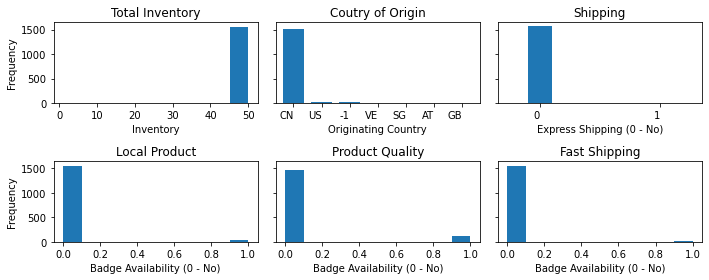

In [271]:
import matplotlib.ticker as mticker

def update_ticks(x, pos):
    return list(counts.keys())[pos]

fig, ax = plt.subplots(2, 3, figsize=(10, 4), sharey=True)

# inventory total histogram
ax[0, 0].hist(df['inventory_total'])
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_xlabel('Inventory')
ax[0, 0].set_xticks(np.arange(0, 60, 10))
ax[0, 0].set_title('Total Inventory')

# origin country histogram 
df['origin_country'].value_counts().plot(ax=ax[0, 1], kind='bar', width=0.75)
ax[0, 1].set_xlabel('Originating Country')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=0, ha='right')
ax[0, 1].set_title('Coutry of Origin')


# express shipping histogram 
df['shipping_is_express'].value_counts().plot(ax=ax[0, 2], kind='bar', width=0.2)
ax[0, 2].set_xlabel('Express Shipping (0 - No)')
ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=0, ha='right')
ax[0, 2].set_title('Shipping')

# badge columns
cols = [col for col in df.columns if 'badge' in col]
col_labels = 'Badge Availability (0 - No)'
col_titles = ['Local Product', 'Product Quality', 'Fast Shipping']

for idx, col in enumerate(cols):
    df[col].hist(ax=ax.flatten()[3+idx])
    ax.flatten()[3+idx].grid(False)
    ax.flatten()[3+idx].set_xlabel(col_labels)
    ax.flatten()[3+idx].set_title(col_titles[idx])
    
    if idx == 0:
        ax.flatten()[3+idx].set_ylabel("Frequency")

fig.tight_layout()
plt.show()

Lastly, the scope of this project will not cover using images in the analysis. Therefore we will also drop features 'merchant_profile_picture', 'product_url', and 'product_picture'.

In [272]:
# drop unncessary features
unwanted = ['merchant_title', 'merchant_name', 'inventory_total', 
            'origin_country', 'shipping_is_express', 'product_url',
            'product_picture', 'merchant_profile_picture',
            'badge_local_product', 'badge_product_quality', 
            'badge_fast_shipping', 'merchant_info_subtitle']
df.drop(unwanted, axis=1, inplace=True)

In [273]:
df.columns

Index(['title', 'price', 'retail_price', 'units_sold', 'uses_ad_boosts',
       'rating_five_count', 'rating_four_count', 'rating_three_count',
       'rating_two_count', 'rating_one_count', 'tags', 'product_color',
       'product_variation_size_id', 'product_variation_inventory',
       'shipping_option_name', 'shipping_option_price', 'countries_shipped_to',
       'urgency_text', 'merchant_rating_count', 'merchant_rating',
       'merchant_id', 'product_id'],
      dtype='object')

### Cleaning Up Relevant Features

Let's look at the features we decided to keep more in detail, to identify cases where we can make simplifying assumptions.

For instance, 'units_sold' is an approximation with the lower bound specified (e.g. 50+ if a unit was sold 60 times, 100+ if sold 120 times, ...). The lowest approximate bound is 10, meaning that products with less than 10 items sold will have their exact values. Let's observe the distribution of this feature:

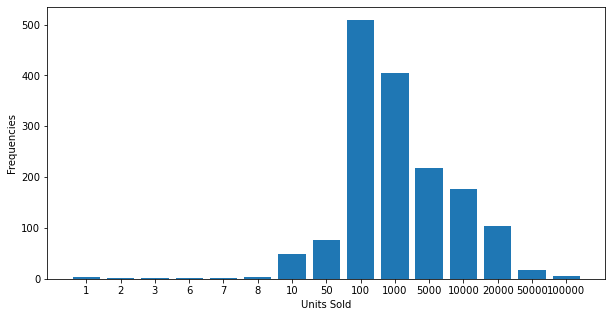

,1,2,3,6,7,8,10,50,100,1000,5000,10000,20000,50000,100000
units_sold,3,2,2,1,2,4,49,76,509,405,217,177,103,17,6


In [274]:
# generate distribution
dist = pd.DataFrame(df['units_sold'].value_counts())
dist.sort_index(axis=0, inplace=True)

# generate plot for units sold frequencies
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(dist)), dist['units_sold'])
plt.xticks(np.arange(len(dist)), dist.index)
plt.xlabel('Units Sold')
plt.ylabel('Frequencies')

plt.show()
dist.T

It is evident that observations with < 10 units sold makes up a very small portion of the dataset. Therefore, we will group them together with the 10+ group. (Although by our convention, they should be in a group of 0+, but having a units sold value of 0 can be very misleading)

In [275]:
# reassign units sold value as 10 for observations < 10
df.loc[df.units_sold < 10, 'units_sold'] = 10

Another feature that could benefit from simplication is product_color. The following issues were observed:

   - Case sensitivity of color names (e.g. red, RED)
   - Different spellings for same color (e.g. gray, grey)
   - Colors too detailed (e.g. skyblue, navyblue, etc)
   - Multi color names (e.g. red & blue)

The first two issues can easily be dealt with, by going through all of the colors and replacing them with a consistent scheme. However, we need to make some simplifying assumptions to deal with the last two issues. Let's look at the break down of product colors:

In [276]:
# counts of each colos
col_counts = df.product_color.value_counts()
col = pd.DataFrame(col_counts).head(20)
col

,product_color
black,302
white,254
yellow,105
pink,99
blue,99
red,93
green,90
grey,71
purple,53
-1,41


To simplify and reduce the number of classes, we will convert all colors to their high-level equivalent (e.g. skyblue to blue). We will keep a list of colors as a feature instead of multiple colors seprated by &.

In [277]:
basic_colors = ['white', 'green', 'black', 'yellow', 'blue', 'beige', 'grey', 
                'orange', 'red', 'pink', 'khaki', 'purple', 'silver', 'brown']

# reduce colors down to its more
def simplify_col(basic_colors, color):
    for basic_col in basic_colors:
        if 'gray' in color.lower():
            return 'grey'
        if basic_col in color.lower():
            return basic_col
    return 'other'
    
for i, row in df.iterrows():
    colors = []
    
    try:
        if '&' in row.product_color:
            colors = row.product_color.split('&')
        else:
            colors = [row.product_color]
    # color label with -1
    except TypeError:
        colors = ['None']
    
    for j, col in enumerate(colors):
        colors[j] = simplify_col(basic_colors, col)
    
    df.at[i, 'product_color'] = '_'.join(colors)

In [278]:
df.product_color.unique()

array(['white', 'green', 'other', 'black', 'yellow', 'blue', 'beige',
       'grey', 'orange', 'red', 'pink', 'khaki', 'red_blue', 'blue_pink',
       'white_green', 'black_green', 'purple', 'orange_other',
       'pink_black', 'silver', 'pink_grey', 'black_white', 'white_black',
       'pink_white', 'brown', 'pink_blue', 'black_other', 'grey_white',
       'brown_yellow', 'red_yellow', 'blue_white', 'white_red',
       'black_yellow', 'black_blue'], dtype=object)

Similarly, feature product_variation_size_id uses various different conventions for displaying sizes as shown below. We can perform a similar operation to simplify the feature. 

In [279]:
col_counts = df.product_variation_size_id.value_counts()
col = pd.DataFrame(col_counts).head(20)
col

,product_variation_size_id
S,641
XS,356
M,200
XXS,100
L,49
S.,18
XL,17
XXL,15
-1,14
XXXS,6


In [280]:
df.loc[df.product_variation_size_id == -1, 'product_variation_size_id'] = 'other'

for i, row in df.iterrows():        
    raw = row.product_variation_size_id.lower()
    raw = ''.join(e for e in raw if e.isalnum()).replace('size', '')  
    num_xs = re.findall(r"(\d+)x", raw)
    
    if len(num_xs) != 0 and len(num_xs[0]) == 1:
        size = raw
    elif all(char.lower() in 'xsml' for char in raw):
        if len(raw) > 2:
            size = str(raw.count('x')) + 'x' + raw[::-1][raw[::-1].find('x') - 1]
        else:
            size = raw
    else:
        size = 'other'
    df.at[i, 'product_variation_size_id'] = size

df.product_variation_size_id = df.product_variation_size_id.map(lambda x: x.upper())

In [281]:
df.product_variation_size_id.unique()

array(['M', 'XS', 'S', '2XS', 'L', '2XL', 'OTHER', '5XL', '3XL', 'XL',
       '3XS', '4XL', '6XL'], dtype=object)

## Exploratory Data Analysis (EDA)

In this section, we will explore our dataset to determine trends and gain insights about factors affecting merchant for a given item. We can first examine the distribution of our datset for certain features of interest.

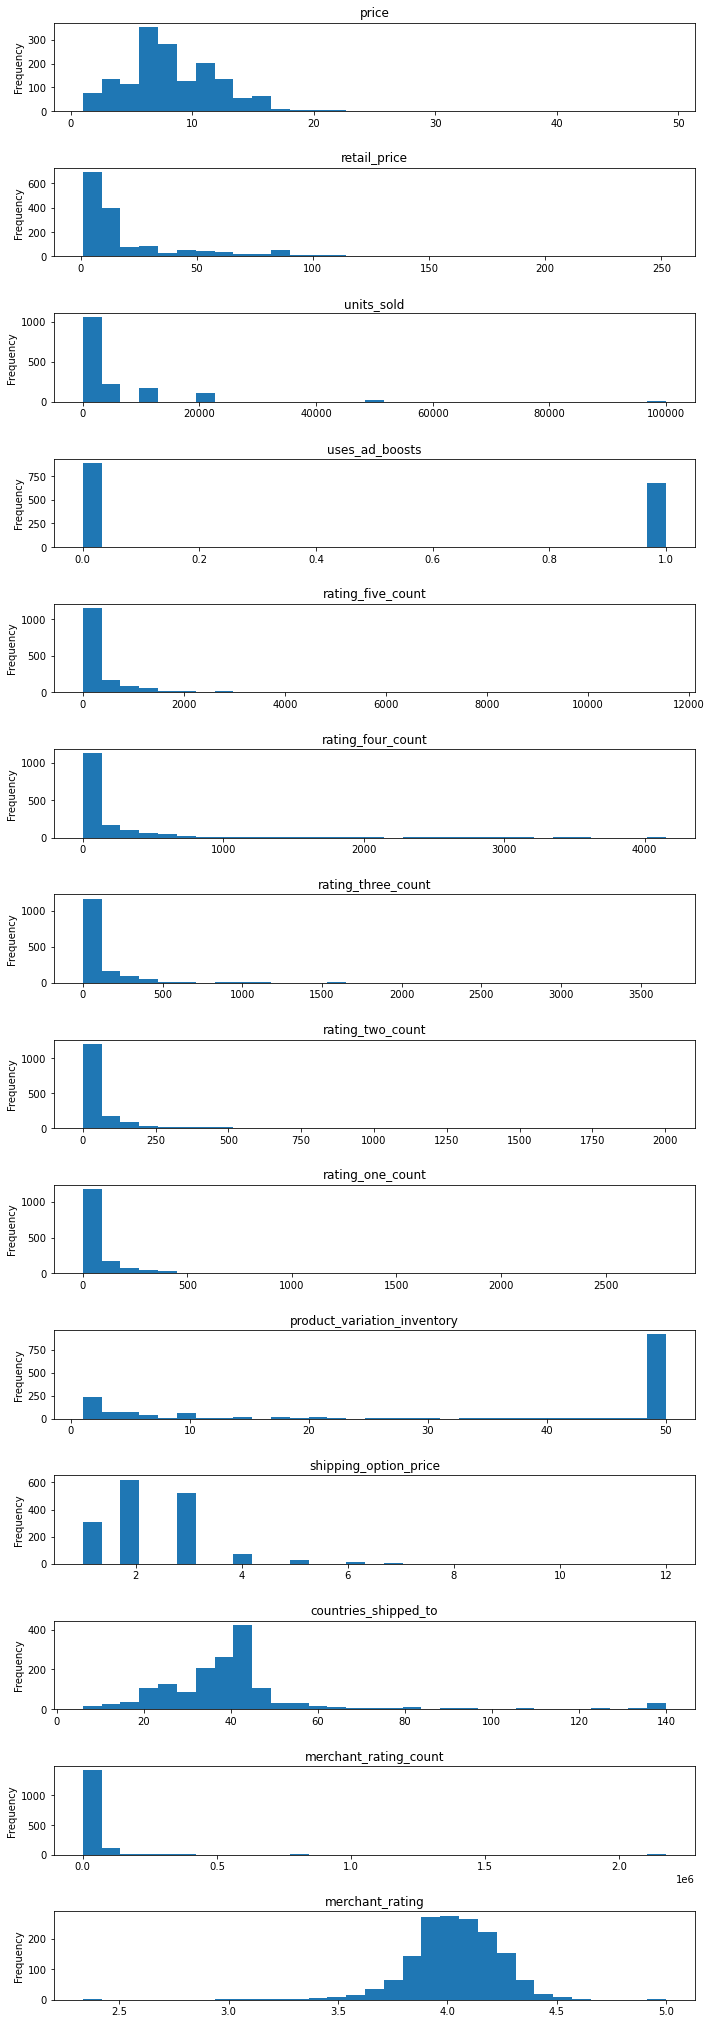

In [282]:
fig = plt.figure(figsize=(10, 30))
columns = 1
rows = 15
count = 0

for col in df.columns:
    if df[col].dtype.name != 'object':
        ax = fig.add_subplot(rows, columns, count+1)
        ax.set_title(col)
        ax.set_ylabel('Frequency')

        plt.hist(df[col], bins=len(df)//50)
        count += 1

plt.tight_layout()
plt.show()

In [283]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,1573.0,8.325372,3.932030,1.000000,5.810000,8.00000,11.000000,49.0
retail_price,1573.0,23.288620,30.357863,1.000000,7.000000,10.00000,26.000000,252.0
units_sold,1573.0,4339.052765,9356.517210,10.000000,100.000000,1000.00000,5000.000000,100000.0
uses_ad_boosts,1573.0,0.432931,0.495639,0.000000,0.000000,0.00000,1.000000,1.0
rating_five_count,1573.0,429.611570,968.882684,0.000000,10.000000,72.00000,394.000000,11548.0
rating_four_count,1573.0,174.461538,395.876511,0.000000,4.000000,29.00000,163.000000,4152.0
rating_three_count,1573.0,130.700572,308.015310,0.000000,3.000000,22.00000,121.000000,3658.0
rating_two_count,1573.0,61.888748,149.539900,0.000000,1.000000,10.00000,59.000000,2003.0
rating_one_count,1573.0,92.996821,211.592341,0.000000,3.000000,18.00000,90.000000,2789.0
product_variation_inventory,1573.0,33.081373,21.353137,1.000000,6.000000,50.00000,50.000000,50.0


We can observe that the retail price is generally higher than the price. This is due to the pricing scheme on Wish, merchants upload the product at their desired retail price, and Wish reduces the price on their system.

A sufficiently large portion of the products are not using ad boosts, we will examine whether ad boosts have a significant correlation with merchant income.

To assess the quality of the products in a quantifiable way, we can also observe if there are significant relationships between ratings_five/ratings_one count and the merchant income. In addition, we can also observe the count of ratings and the mean rating for the merchant as well.

On a related note, we also observe the number of ratings per purchase, and confirm whether ratings count has a significant relationship with merchant income.

We can also verify whether products with "summer colors" (i.e. bright, flamboyant) sell better than darker shaded colors during the summer.

The users of Wish can view both the price and the retail price for some of the items (it is unclear why it does not show this information for all products, it could be that the ones not shown have price and retail price to be very similar, or have the retail price at a lower value). We will verify whether the dollar value reduction has a significant import on the merchant income.

Lastly, we can cluster our observations, which will allow us to make comparisons at both the inter-cluster and intra-cluster levels, to determine if there are meaningful patterns to be observed on the successfulness of a product.

Since units_sold is provided as lower bound approximations (i.e. 50+, 100+, etc.) it is difficult to directly compare the number of units sold and other features to draw meaningful conclusions. Therefore, we will classify a product by its success, using the median value of revenue of each product. 

In [284]:
# compute revenue
df['rev'] = df['price'] * df['units_sold']
df[['rev']].describe().T

,count,mean,std,min,25%,50%,75%,max
rev,1573.0,35211.941704,72649.668092,20.0,800.0,7000.0,40000.0,800000.0


As seen above, the median revenue is \\$7000 for all products in the dataset. All products with revenue generated less than \\$7000 will be classified as 'unsuccessful', and otherwise 'successful.'

In [285]:
df['uses_ad_boosts'].value_counts() / len(df)

0    0.567069
1    0.432931
Name: uses_ad_boosts, dtype: float64

In [286]:
df['success'] = df.eval('rev > {}'.format(7000))
print("Percentage of ad boosted products within succesful products: {:.2f} %".format(
    100* len(df[(df.uses_ad_boosts == 1) & (df.success == True)])/len(df[(df.success == True)])))                     

Percentage of ad boosted products within succesful products: 40.97 %


The results display that the proportion of ad boosted products is maintained when the threshold for success is at \\$7000. Let's observe whether this is true for a wider range of thresholds

In [287]:
threshold = np.arange(0, 40000, 1000)
ad_succ_rate = []

for thresh in threshold:
    df['success'] = df.eval('rev > {}'.format(thresh))
    ad_succ_rate.append(len(df[(df.uses_ad_boosts == 1) & (df.success == True)])/len(df[(df.success == True)]))

non_ad_succ_rate = [1 - x for x in ad_succ_rate]

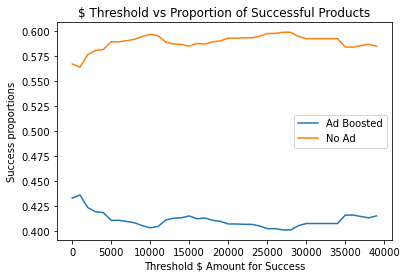

Ratio b/w two proportions: 1.4335 +/- 0.0426


In [288]:
fig, ax = plt.subplots()

ax.plot(threshold, ad_succ_rate, label='Ad Boosted')
ax.plot(threshold, non_ad_succ_rate, label='No Ad')
ax.set_xlabel('Threshold $ Amount for Success')
ax.set_ylabel('Success proportions')
ax.set_title("$ Threshold vs Proportion of Successful Products")
ax.legend()

plt.show()

ratio = [non_ad_succ_rate[i]/ad_succ_rate[i] for i in range(len(ad_succ_rate))]
print("Ratio b/w two proportions: {:.4f} +/- {:.4f}".format(np.mean(ratio), np.std(ratio)))

It's quite interesting to see here that the ratios of ad boosted to non ad boosted remains more or less constant, and it seems that ad boosting does not significantly attribute to the success of a product.

Let us now move on to observing how rating count of each value affects the merchant income.

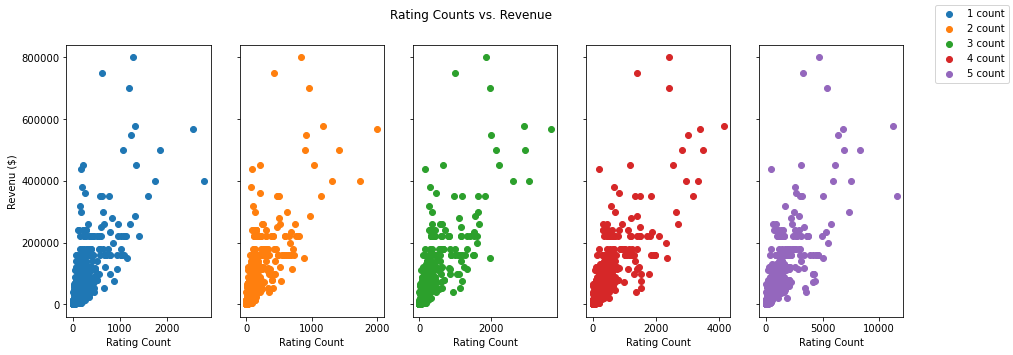

In [289]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
cols = ['rating_one_count', 'rating_two_count', 'rating_three_count', 'rating_four_count', 'rating_five_count']
col_label = ['{} count'.format(i) for i in range(1, 6)]
color = ['C{}'.format(i) for i in range(5)]
lines = []

for idx, ax in enumerate(axes):
    lines.append(ax.scatter(df[cols[idx]], df['rev'], label=col_label[idx], color=color[idx]))
    ax.set_yticks(np.round(np.linspace(0, 800000, 5), 2))
    
    if idx == 0:
        ax.set_ylabel('Revenu ($)')
    ax.set_xlabel('Rating Count')

fig.suptitle("Rating Counts vs. Revenue")
fig.legend(lines, col_label)

plt.show()

In [290]:
df[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
rating_one_count,1573.0,92.996821,211.592341,0.0,3.0,18.0,90.0,2789.0
rating_two_count,1573.0,61.888748,149.539900,0.0,1.0,10.0,59.0,2003.0
rating_three_count,1573.0,130.700572,308.015310,0.0,3.0,22.0,121.0,3658.0
rating_four_count,1573.0,174.461538,395.876511,0.0,4.0,29.0,163.0,4152.0
rating_five_count,1573.0,429.611570,968.882684,0.0,10.0,72.0,394.0,11548.0


It seems that the ceiling for the count of ratings is much higher for five starts, and that people are more likely to leave ratings when satistifed. Overall, there seems to be a positive linear relationship between the number of ratings and the revenue from a product. This may be due to the fact the regardless of the rating value, each rating entry translates to product sales. It may also be that some product may simultanesouly have very high one start counts as well as five star counts. Another point worth noting is that the units sold feature is provided as a lower bound approximate, not actual sales values. 

We can now verify with purchases per ratings to see if higher rating density does translate to higher sales

In [291]:
df['rating_count'] = (df['rating_one_count'] + df['rating_two_count'] + df['rating_three_count'] + df['rating_four_count'] + df['rating_five_count'])
df['rating_density'] = df['rating_count']/df['rev'] 

scaler = MinMaxScaler()
scaler.fit(np.array(df['rating_density']).reshape(-1, 1))

df['rating_density'] = scaler.transform(np.array(df['rating_density']).reshape(-1, 1))

In [292]:
df[['rating_density']].describe().T

,count,mean,std,min,25%,50%,75%,max
rating_density,1573.0,0.07083,0.083148,0.0,0.027246,0.048582,0.083863,1.0


Let's divide the observations into 4 groups, div from the rating density, and observe if there are meaningful differences in the revenue

In [293]:
quartile = df.rating_density.quantile([0, 0.25, 0.5, 0.75, 1])

df['group'] = df.rating_density.map(lambda x: 1 if x < quartile[0.25] else 
                                              2 if x < quartile[0.5] else
                                              3 if x < quartile[0.75] else 4)

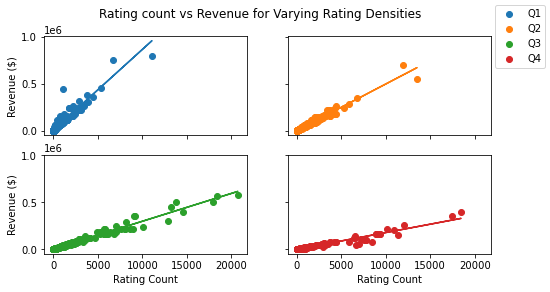

In [294]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,4))
col_labels = ['Q{}'.format(i) for i in range(1, 5)]
lines = []

lines.append(axes[0,0].scatter(df[df.group == 1]['rating_count'], df[df.group == 1]['rev'], label='Q1', color='C0'))
lines.append(axes[0,1].scatter(df[df.group == 2]['rating_count'], df[df.group == 2]['rev'], label='Q2', color='C1'))
lines.append(axes[1,0].scatter(df[df.group == 3]['rating_count'], df[df.group == 3]['rev'], label='Q3', color='C2'))
lines.append(axes[1,1].scatter(df[df.group == 4]['rating_count'], df[df.group == 4]['rev'], label='Q4', color='C3'))
    
axes[0,0].set_ylabel('Revenue ($)')
axes[1,0].set_ylabel('Revenue ($)')
axes[1,0].set_xlabel('Rating Count')
axes[1,1].set_xlabel('Rating Count')

for i in range(1, 5):
    ax = axes.flatten()[i-1]
    coef = np.polyfit(df[df.group == i]['rating_count'], df[df.group == i]['rev'], 1)
    poly1d_fn = np.poly1d(coef)

    ax.plot(df[df.group == i]['rating_count'], poly1d_fn(df[df.group == i]['rating_count']), color='C{}'.format(i-1))

fig.legend(lines, col_labels)
fig.suptitle("Rating count vs Revenue for Varying Rating Densities")

plt.show()

It seems that the ceiling for the rating count is higher for the groups with higher rating density. There seems to be a significant positive linear relationship between rating count and revenue and groped by rating density quartile.

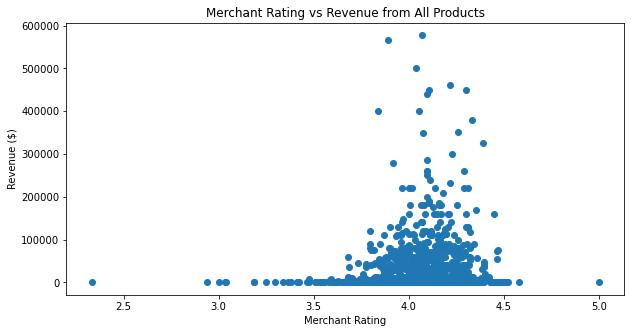

In [295]:
fig, ax = plt.subplots(figsize=(10, 5))

test = df[['merchant_rating', 'rev']]
test = df.groupby(['merchant_id']).mean()

ax.scatter(test['merchant_rating'], test['rev'])
ax.set_xlabel('Merchant Rating')
ax.set_ylabel('Revenue ($)')
ax.set_title("Merchant Rating vs Revenue from All Products")

plt.show()

In [296]:
test[['rev']].describe().T

,count,mean,std,min,25%,50%,75%,max
rev,958.0,35687.357604,67618.331623,20.0,900.0,8000.0,44912.5,577000.0


It seems that the merchant rating does not have a significant linear relationship with the mean revenue from all products. Most merchant ratings seem to be around ~4.0, with the highest mean rating of approximately \\$600000.

In [297]:
df['val_reduction'] = df['retail_price'] - df['price']
df['perc_reduction'] = df['val_reduction']/df['retail_price']

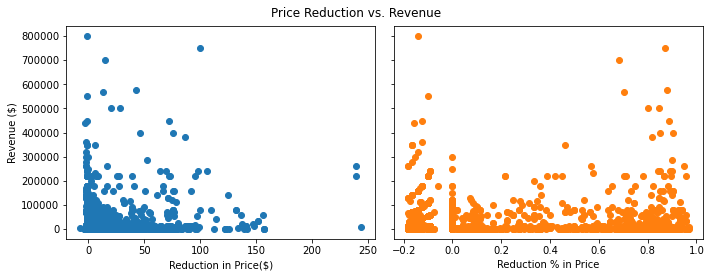

In [298]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)


axes[0].scatter(df['val_reduction'], df['rev'], color='C0')
axes[0].set_xlabel('Reduction in Price($)')
axes[0].set_ylabel('Revenue ($)')

axes[1].scatter(df['perc_reduction'], df['rev'], color='C1')
axes[1].set_xlabel('Reduction % in Price')

fig.suptitle("Price Reduction vs. Revenue")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

There seems to be no significant relationship between price reducion and revenue, as the relationship seems more or less random. It may be that the price reduction actually has no correlation with revenue, or that since price reduction is only selectively shown for a subset of the products, we are unable to capture the user behaviour.

In [299]:
order = ['3XS', '2XS', 'XS', 'S', 'M', 'L', 'XL', '2XL', '3XL',
         '4XL', '5XL', '6XL', 'OTHER']

df['product_variation_size_id'] = pd.Categorical(df['product_variation_size_id'],

                                                 categories=order, ordered=True)

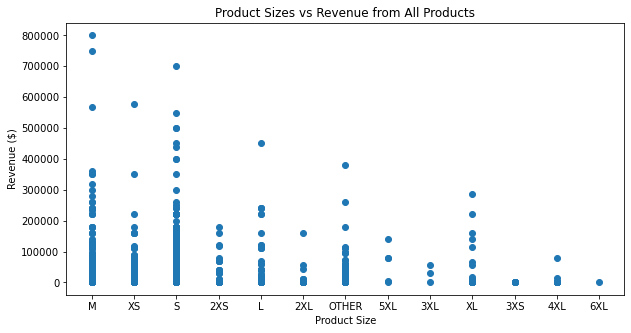

In [300]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(df['product_variation_size_id'], df['rev'])
ax.set_xlabel('Product Size')
ax.set_ylabel('Revenue ($)')
ax.set_title("Product Sizes vs Revenue from All Products")

plt.show()

In [301]:
df.product_variation_size_id.value_counts()

S        680
XS       369
M        206
2XS      107
OTHER     95
L         54
2XL       19
XL        18
4XL       10
3XS        6
5XL        5
3XL        3
6XL        1
Name: product_variation_size_id, dtype: int64

As expected, products have the most quantity of the sizes that may fit the average body types (i.e. XS, S, M). It is evident that the largest revenue generating products also fall within this size.

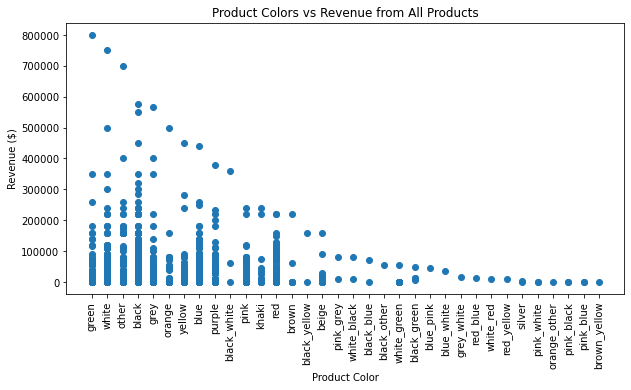

In [302]:
df.sort_values('rev', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(df['product_color'], df['rev'])
ax.set_xlabel('Product Color')
ax.set_ylabel('Revenue ($)')
ax.set_title("Product Colors vs Revenue from All Products")
ax.tick_params(axis='x', rotation=90)

plt.show()

In [303]:
df.product_color.value_counts().head(10)

black     308
white     262
blue      160
red       138
green     137
other     109
yellow    107
pink      107
grey       85
purple     54
Name: product_color, dtype: int64

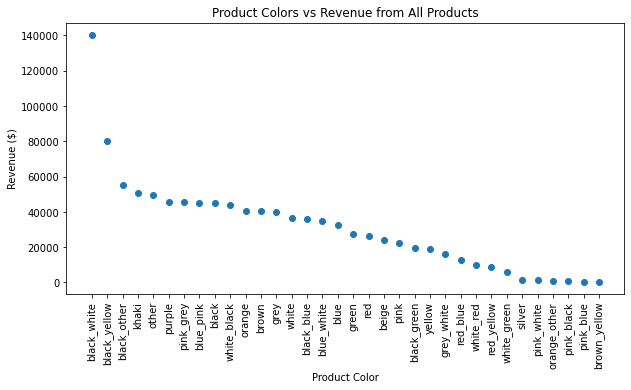

In [304]:
test = df.groupby(['product_color']).mean()

test.sort_values('rev', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(test.index, test['rev'])
ax.set_xlabel('Product Color')
ax.set_ylabel('Revenue ($)')
ax.set_title("Product Colors vs Revenue from All Products")
ax.tick_params(axis='x', rotation=90)

plt.show()

The most widely available colors for the summer sale dataset was black, white, and blue. Color green had the product with the highest revenue, but the mean revenue was highest by far for black & white, followed by black & yellow and black & other. It seems that brighter summer colors do not significantly impact the sales of summer items.

Now that we've explored the dataset a bit, we can cluster the dataset to identify similarities/differences between inter/intra-cluester observations. However, it is often a bad idea to cluster high dimensional data directly. You are likely to achieve better results by first applying dimensionality reduction techniques prior to clustering.

Principal Component Analysis (PCA) is a technique that allows you to reduce the number of features by identifying the principal components (i.e. orthogonal components with highest variance in dataset), resulting in a smaller number of components than you begin with, each resulting component being uncorrelated. Extending from this idea, Generalized Low Rank Models (GLRM) takes a more systemic approach dimensionality reduction, using more robust loss functions (as opposed to least squares) for categorical/ordinal/boolean variables. We will reduce the dimensionality of our dataset using GLRM, then apply various clustering algorithms.

In [305]:
# drop columns not relevant to clustering
drop = ['title', 'merchant_id', 'tags',
        'product_id', 'rev', 'success', 'rating_count', 'rating_density',
        'group', 'val_reduction', 'perc_reduction']
df_clusters = df.drop(drop, axis=1)

In [306]:
# initialize H2O instance
h2o.init()
h2o.remove_all()

# re-read dataframe as H2O frame
df_clusters.to_csv('clusters.csv')
hf = h2o.import_file(path='clusters.csv')

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 6 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_jwoo_toyg65
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.972 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [307]:
glrm_model = h2o.estimators.H2OGeneralizedLowRankEstimator(training_frame=hf, k = 3,
                                           transform="STANDARDIZE",
                                           loss="Huber",
                                           multi_loss='Categorical',
                                           regularization_x = "Quadratic",
                                           regularization_y = "L2",
                                           gamma_x = 0.1,
                                           gamma_y = 0.1,
                                           max_iterations = 175)

glrm_model.train()

glrm Model Build progress: |██████████████████████████████████████████████| 100%


After fitting the GLRM model, we can check the convergence of the model by observing the loss history, where the loss is the error between the original data matrix and the matrix constructed from the low rank approximation.

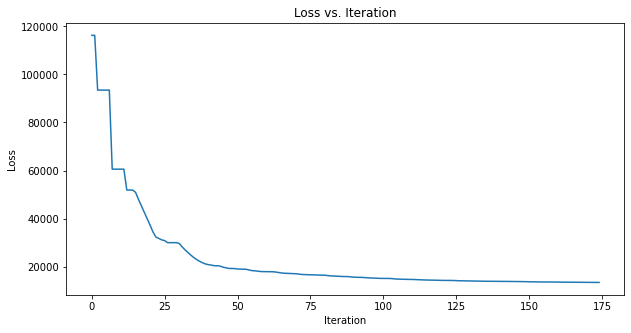

In [308]:
score = glrm_model.score_history()
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(score["iterations"], score["objective"])
ax.set_xlabel('Iteration')
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Iteration")

plt.show()

In [309]:
X = h2o.get_frame(glrm_model._model_json["output"]["representation_name"])
X.head(5)

Arch1,Arch2,Arch3
0.688195,0.548177,-0.00259945
0.214083,0.229328,0.536614
1.00979,1.09475,-0.0902854
0.697552,0.470976,1.00427
0.765973,0.548442,0.124558


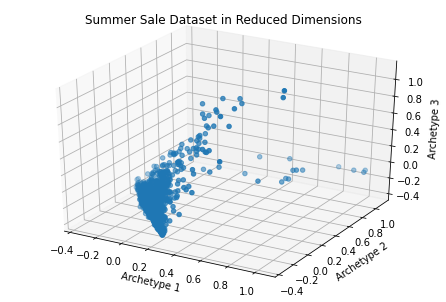

In [310]:
fig = plt.figure()
ax = Axes3D(fig)

arch = np.array(h2o.as_list(X[:,[0, 1, 2]]))
ax.scatter(arch[:, 0], arch[:, 1], arch[:, 2])
ax.set_xlabel('Archetype 1')
ax.set_ylabel('Archetype 2')
ax.set_zlabel('Archetype 3')
ax.set_title("Summer Sale Dataset in Reduced Dimensions")

plt.show()

The above is the plot of the summer sales dataset projected to a 3 dimensional space, where each axis represents an archetype (i.e. condensed features). We can now apply clustering algorithms in this latent space.

In [311]:
test = pd.DataFrame(arch, columns=['archetype_{}'.format(i) for i in range(1, 4)])
test.head()

,archetype_1,archetype_2,archetype_3
0,0.688195,0.548177,-0.002599
1,0.214083,0.229328,0.536614
2,1.009787,1.094752,-0.090285
3,0.697552,0.470976,1.004270
4,0.765973,0.548442,0.124558


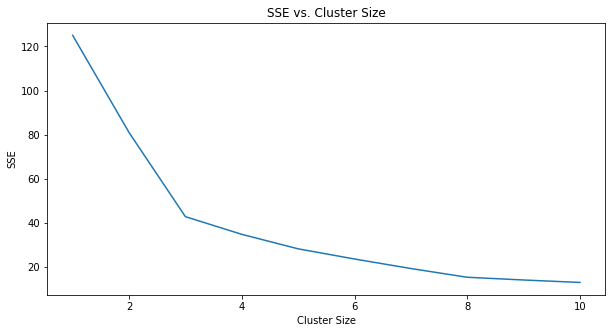

In [312]:
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM).fit(test)
    test['km_labels'] = kmeans.labels_
    sse.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(1, 11), sse)
ax.set_xlabel('Cluster Size')
ax.set_ylabel('SSE')
ax.set_title("SSE vs. Cluster Size")

plt.show()

It is evident that the "elbow" is present at k=3, therefore we will take k as 3 to cluster our dataset.

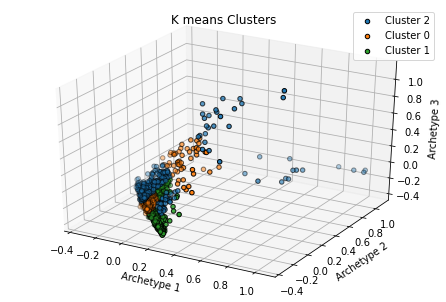

In [326]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM).fit(test)
test['km_labels'] = kmeans.labels_

fig = plt.figure()
ax = Axes3D(fig)

colors = ['red', 'blue', 'green']

for idx, val in enumerate(test.km_labels.unique()):
    curr_df = test[test.km_labels == val]
    ax.scatter(curr_df['archetype_1'], curr_df['archetype_2'], curr_df['archetype_3'],
               color='C{}'.format(idx), edgecolor='black', label='Cluster {}'.format(val))
    
    
ax.set_xlabel('Archetype 1')
ax.set_ylabel('Archetype 2')
ax.set_zlabel('Archetype 3')
ax.set_title("K means Clusters")
ax.legend()

plt.show()

In [327]:
test.km_labels.value_counts()

1    605
0    540
2    428
Name: km_labels, dtype: int64

The drawbacks of K Means clustering is that it is sensitive to outliers, and it is not good for identifying non spherical clusters in the dataspace. To identify clusters with varying shapes or densities, there are more robust clsutering algorithms.

DBSCAN is a density based clustering algorithm that identifies clusters by defining the minimum number of points to form a cluster, and the radius epsilon to assign assign a cluster. The algorithm tries to identify dense regions as defined by the parameters, and thus will benefit from the dimensionality reduction.

In [315]:
db = DBSCAN(eps=0.7, min_samples=150).fit(test)
test['db_labels'] = db.labels_

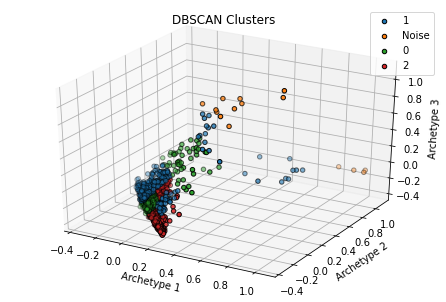

In [316]:
fig = plt.figure()
ax = Axes3D(fig)

colors = ['red', 'blue', 'green']

for idx, val in enumerate(test.db_labels.unique()):
    label = val if val != -1 else 'Noise'
    curr_df = test[test.db_labels == val]
    ax.scatter(curr_df['archetype_1'], curr_df['archetype_2'], curr_df['archetype_3'],
               color='C{}'.format(idx), edgecolor='black', label=label)
    
    
ax.set_xlabel('Archetype 1')
ax.set_ylabel('Archetype 2')
ax.set_zlabel('Archetype 3')
ax.set_title("DBSCAN Clusters")
ax.legend()

plt.show()

In [317]:
test.db_labels.value_counts()

 2    605
 0    540
 1    413
-1     15
Name: db_labels, dtype: int64

Interestingly enough, the clusters formed from K Means and DBSCAN are quite similar, with the addition of observations labelled as noise with DBSCAN.

The drawbacks of DBSCAN is that although it is good for identifying dense regions in the dataspace, it requires a predefined notion of density before running the algorithm. The results of the algorithm are highly dependent on the parameters that you choose.

HDBSCAN is an extension of DBSCAN that allows regions of varying density by applying DBSCAN over varying epsilon values and integrating the results to find clsuters that gives the best stability. This allows the parameter selection to be more robust.

In [318]:
hdb = hdbscan.HDBSCAN(min_cluster_size=150).fit(test)
test['hdb_labels'] = hdb.labels_

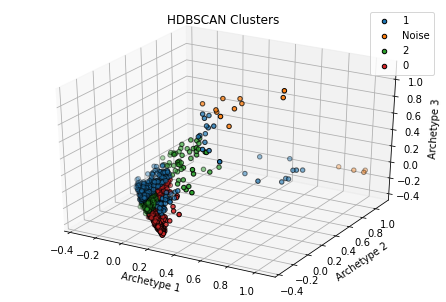

In [319]:
fig = plt.figure()
ax = Axes3D(fig)

colors = ['red', 'blue', 'green']

for idx, val in enumerate(test.hdb_labels.unique()):
    label = val if val != -1 else 'Noise'
    curr_df = test[test.hdb_labels == val]
    ax.scatter(curr_df['archetype_1'], curr_df['archetype_2'], curr_df['archetype_3'],
               color='C{}'.format(idx), edgecolor='black', label=label)
    
    
ax.set_xlabel('Archetype 1')
ax.set_ylabel('Archetype 2')
ax.set_zlabel('Archetype 3')
ax.set_title("HDBSCAN Clusters")
ax.legend()

plt.show()

In [320]:
test.hdb_labels.value_counts()

 0    605
 2    540
 1    413
-1     15
Name: hdb_labels, dtype: int64

Again, the clusters generated seem to resemble the previous two attempts. We will use the clusters generated with HDBSCAN to identify insights/patterns in our dataset

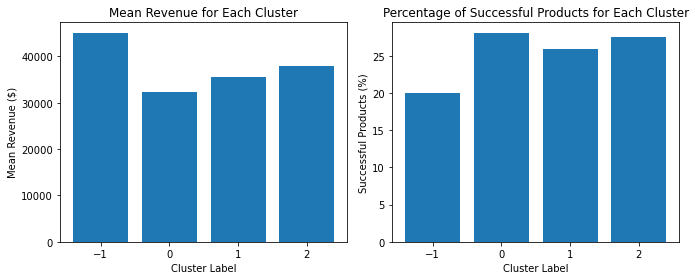

In [328]:
df['labels'] = test['hdb_labels']

# mean values for revenue for each cluster
rev_mean = [df[df.labels == i].rev.mean() for i in range(-1, 3)]
num_good_obs = [len(df[(df.labels == i) & (df.rev > rev_mean[i+1])])/len(df[df.labels == i])* 100 for i in range(-1, 3)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(range(-1, 3), rev_mean)
ax[0].set_xlabel('Cluster Label')
ax[0].set_xticks(np.arange(-1, 3, 1))
ax[0].set_ylabel('Mean Revenue ($)')
ax[0].set_title("Mean Revenue for Each Cluster")

ax[1].bar(range(-1, 3), num_good_obs)
ax[1].set_xlabel('Cluster Label')
ax[1].set_xticks(np.arange(-1, 3, 1))
ax[1].set_ylabel('Successful Products (%)')
ax[1].set_title("Percentage of Successful Products for Each Cluster")

fig.tight_layout()
plt.show()

In [329]:
for i in range(-1, 3):
    curr_df = df[df['labels'] == i]
    print('Cluster {}'.format(i))
    print(curr_df[['rev']].describe().T)
    print()

Cluster -1
     count          mean           std   min    25%     50%      75%       max
rev   15.0  45094.546667  91878.306048  39.2  750.0  9000.0  34450.0  350000.0

Cluster 0
     count          mean           std   min    25%     50%      75%       max
rev  605.0  32392.550413  64540.403253  20.0  800.0  6000.0  40000.0  750000.0

Cluster 1
     count          mean           std   min    25%     50%      75%       max
rev  413.0  35529.489346  76723.318107  37.0  800.0  7000.0  40000.0  800000.0

Cluster 2
     count          mean           std   min    25%     50%      75%       max
rev  540.0  37853.322222  77382.322913  20.0  700.0  7000.0  40000.0  700000.0



Earlier, we defined the notion of sucess with a constant threshold dollar value. We can now redefine a product to be successful if it performs better compared to the average revenue generated from similar products in its clusters. 

We can see that the noise cluster has the smallest proportion of successful products within the cluster, while having the second highest mean revenue. This is likely due to the fact that the noise cluster isn't an actual cluster that is formed, but an aggregation of all observations labelled as noise.

Items in cluster 2 have to lowest mean revenue, but have the highest percentage of successful products. Clusters 1 and 2 seem to have similar metrics for mean revenue and the percentage of successful products

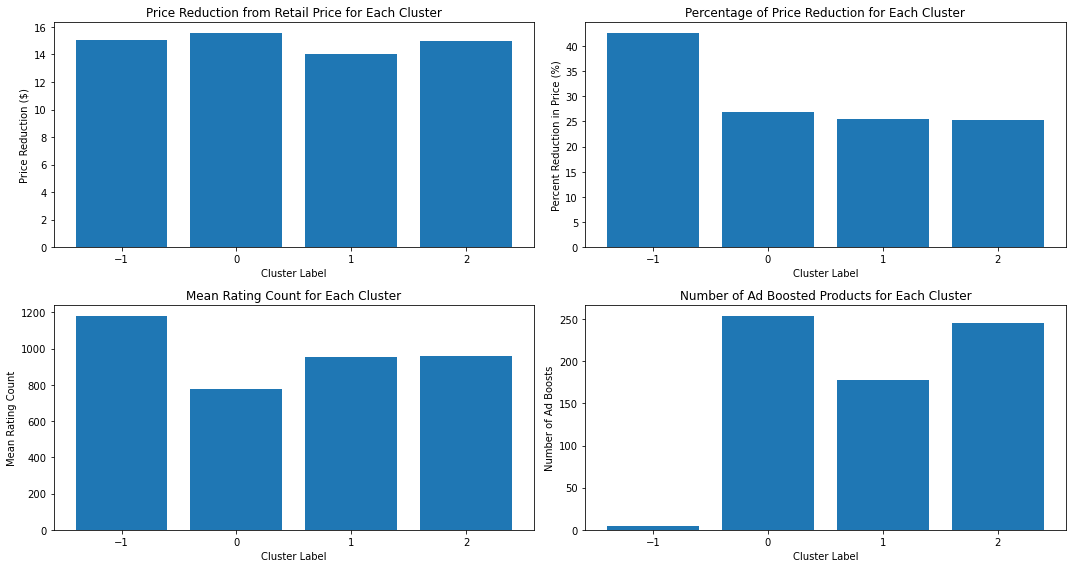

In [330]:
# price reduction rating count # perc reduction #uses ad boosts count
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
price_red = [df[df.labels == i].val_reduction.mean() for i in range(-1, 3)]
rating_count = [df[df.labels == i].rating_count.mean() for i in range(-1, 3)]
perc_red = [df[df.labels == i].perc_reduction.mean()* 100 for i in range(-1, 3)]
ad_count = [len(df[(df.labels == i) & (df.uses_ad_boosts == 1)]) for i in range(-1, 3)]


ax[0, 0].bar(range(-1, 3), price_red)
ax[0, 0].set_xlabel('Cluster Label')
ax[0, 0].set_xticks(np.arange(-1, 3, 1))
ax[0, 0].set_ylabel('Price Reduction ($)')
ax[0, 0].set_title("Price Reduction from Retail Price for Each Cluster")

ax[0, 1].bar(range(-1, 3), perc_red)
ax[0, 1].set_xlabel('Cluster Label')
ax[0, 1].set_xticks(np.arange(-1, 3, 1))
ax[0, 1].set_ylabel('Percent Reduction in Price (%)')
ax[0, 1].set_title("Percentage of Price Reduction for Each Cluster")

ax[1, 0].bar(range(-1, 3), rating_count)
ax[1, 0].set_xlabel('Cluster Label')
ax[1, 0].set_xticks(np.arange(-1, 3, 1))
ax[1, 0].set_ylabel('Mean Rating Count')
ax[1, 0].set_title("Mean Rating Count for Each Cluster")

ax[1, 1].bar(range(-1, 3), ad_count)
ax[1, 1].set_xlabel('Cluster Label')
ax[1, 1].set_xticks(np.arange(-1, 3, 1))
ax[1, 1].set_ylabel('Number of Ad Boosts')
ax[1, 1].set_title("Number of Ad Boosted Products for Each Cluster")

fig.tight_layout()
plt.show()